In [7]:
import numpy as np
import pandas as pd


In [8]:
from google.colab import drive


#Mount Google Drive
drive.mount('/content/MyDrive/')

Mounted at /content/MyDrive/


In [9]:
# Define the path to the excel file (replace with your file path on Google Drive)
file_path = '/content/MyDrive/MyDrive/df14.csv'

In [10]:
# Read the .csv file into a DataFrame
df14 = pd.read_csv(file_path)

In [11]:
# Display the first few rows of the DataFrame
print(df14.head())

              Datetime        NO2       PM10     PM2.5     RH       Temp  \
0  2018-01-01 00:00:00  64.216400  14.020000  6.980000  65.84  20.880000   
1  2018-01-01 01:00:00  46.040667  15.966667  8.900000  65.84  21.116667   
2  2018-01-01 02:00:00  28.285000  12.050000  5.183333  65.84  20.716667   
3  2018-01-01 03:00:00  24.381333  12.750000  5.133333  65.84  20.383333   
4  2018-01-01 04:00:00  21.431167  10.700000  4.250000  65.84  20.466667   

           WD        WS  
0   80.880000  0.300000  
1  152.250000  0.233333  
2  163.016667  0.266667  
3   55.550000  0.233333  
4   33.583333  0.250000  


In [12]:
# Calculate the percentage of missing values per column
missing_percentage = df14.isnull().mean() * 100

# Print the missing percentage per column
print("Percentage of missing values per column:")
print(missing_percentage)

Percentage of missing values per column:
Datetime    0.0
NO2         0.0
PM10        0.0
PM2.5       0.0
RH          0.0
Temp        0.0
WD          0.0
WS          0.0
dtype: float64


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load dataset (ensure 'Datetime' is parsed correctly)
df = pd.read_csv(file_path, parse_dates=["Datetime"], index_col="Datetime")

# Select features (excluding NO2 itself to prevent data leakage)
features = ["PM10", "PM2.5", "RH", "Temp", "WD", "WS"]

# Create lag features for NO2
for lag in range(1, 25):  # Using past 24 hours of NO2 data
    df[f"NO2_lag{lag}"] = df["NO2"].shift(lag)

# Drop NaN values after lag creation
df = df.dropna()

# Define X (independent variables) and y (target variable)
X = df[features + [f"NO2_lag{lag}" for lag in range(1, 25)]]
y = df["NO2"]

# Standardize features (not target variable)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
#train test split
train_size = int(0.8 * len(df))  # 80% training, 20% testing
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [15]:
#Train the Random Forest Model
# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)


In [16]:
#Evaluate model performance
# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)  # Remove squared parameter
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE manually
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")


MAE: 3.903
RMSE: 7.508
R² Score: 0.950


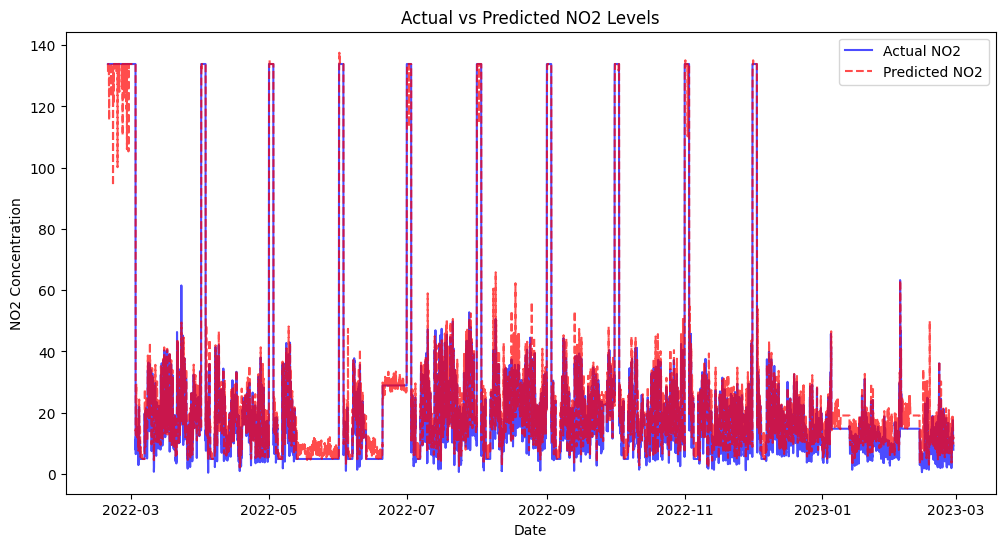

In [17]:
#visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual NO2", color="blue", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted NO2", color="red", linestyle="dashed", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("NO2 Concentration")
plt.title("Actual vs Predicted NO2 Levels")
plt.legend()
plt.show()



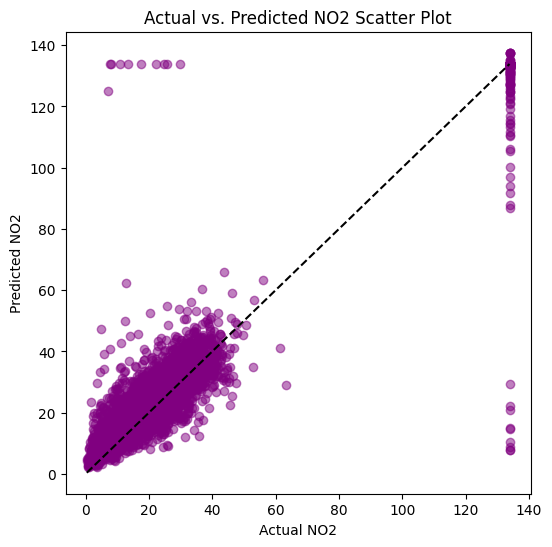

In [18]:
#scater splot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="purple")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="dashed", color="black")  # 45-degree reference line
plt.xlabel("Actual NO2")
plt.ylabel("Predicted NO2")
plt.title("Actual vs. Predicted NO2 Scatter Plot")
plt.show()


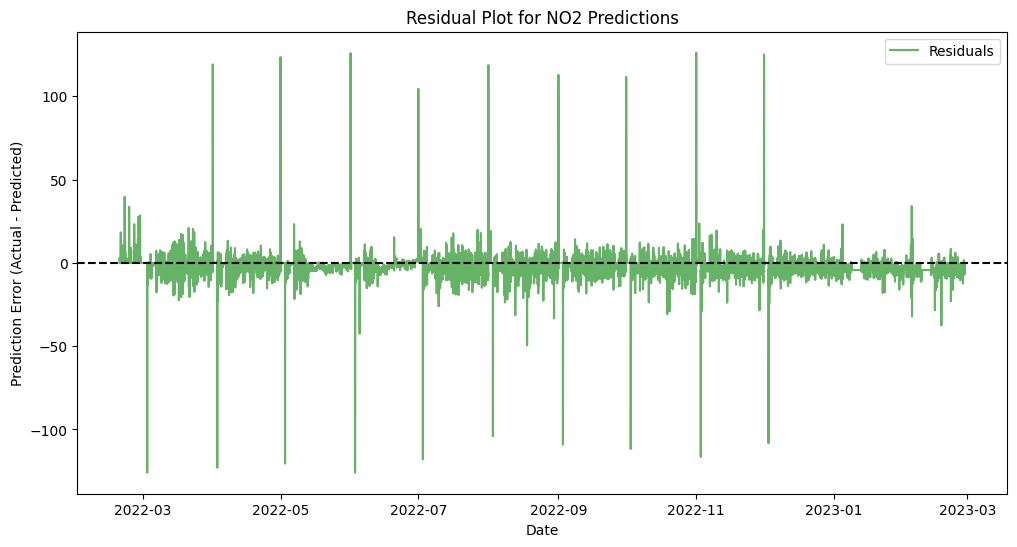

In [19]:
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, residuals, label="Residuals", color="green", alpha=0.6)
plt.axhline(0, linestyle="dashed", color="black")  # Zero error reference line
plt.xlabel("Date")
plt.ylabel("Prediction Error (Actual - Predicted)")
plt.title("Residual Plot for NO2 Predictions")
plt.legend()
plt.show()


In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


#prediction 2023, 2025
# Prediction for 2023 and 2025
future_dates = pd.date_range(start="2023-03-01 00:00:00", end="2025-12-31 23:00:00", freq="H")
future_df = pd.DataFrame(index=future_dates, columns=['NO2_Predicted'])  # Initialize with 'NO2_Predicted' column
future_df['NO2_Predicted'] = np.zeros(len(future_dates))

# Loop to make predictions for each future hour:
for i, date in enumerate(future_dates):
    # Prepare features for prediction (replace with your feature engineering logic) Using the mean of the last 24 hours for each feature
    # If i < 24, use the last 24 hours from the original df, otherwise use previous predictions
    if i < 24:
        features_for_prediction = df[features].tail(24).iloc[i].values.reshape(1, -1)
        # Add lag features from the original data for the first 24 predictions
        lag_features = df[[f"NO2_lag{lag}" for lag in range(1, 25)]].tail(24).iloc[i].values
        features_for_prediction = np.concatenate([features_for_prediction, lag_features.reshape(1, -1)], axis=1)
    else:
        # Use the previous 24 hours of predicted NO2 as lag features along with other features
        past_no2 = future_df["NO2_Predicted"].iloc[i-24:i].values
        # The fix: Use the last row of df[features] instead of trying to access an out-of-bounds row
        features_for_prediction = np.concatenate([df[features].tail(1).iloc[0].values, past_no2]).reshape(1, -1)

    # Make prediction for the current date and store it in the future_df DataFrame
    future_df.loc[date, "NO2_Predicted"] = rf_model.predict(scaler.transform(features_for_prediction))[0]

# Save predictions to CSV
future_df[["NO2_Predicted"]].to_csv("NO2_Forecast_2024_2025.csv")
print("Predictions saved successfully!")

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(

Predictions saved successfully!


In [ ]:
# Save predictions to CSV
future_df[["NO2_Predicted"]].to_csv("NO2_Forecast_2024_2025.csv")

print("Predictions saved successfully!")


Predictions saved successfully!


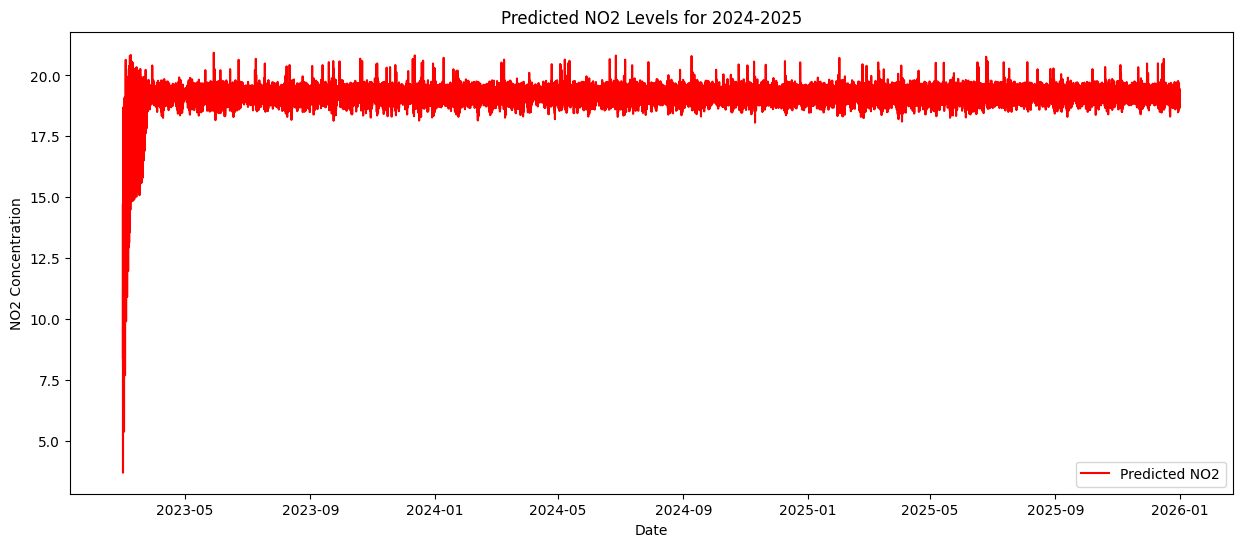

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(future_df.index, future_df["NO2_Predicted"], label="Predicted NO2", color="red")
plt.xlabel("Date")
plt.ylabel("NO2 Concentration")
plt.title("Predicted NO2 Levels for 2024-2025")
plt.legend()
plt.show()


In [76]:
# Import the pandas library at the beginning of this cell.
import pandas as pd

In [77]:
# Define the path to the excel file (replace with your file path on Google Drive)
file_path = '/content/MyDrive/MyDrive/NO2_Forecast_2024_2025.csv'

In [78]:
# Read the .csv file into a DataFrame
dfPred = pd.read_csv(file_path)

In [79]:
# Display the first few rows of the DataFrame
print(dfPred.head())

            Unnamed: 0  NO2_Predicted
0  2023-03-01 00:00:00       8.415742
1  2023-03-01 01:00:00      14.727916
2  2023-03-01 02:00:00       6.884728
3  2023-03-01 03:00:00       3.695629
4  2023-03-01 04:00:00       6.244288


In [80]:
dfPred.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24888 entries, 0 to 24887
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     24888 non-null  object 
 1   NO2_Predicted  24888 non-null  float64
dtypes: float64(1), object(1)
memory usage: 389.0+ KB


In [81]:
# Calculate the percentage of missing values per column
missing_percentage = dfPred.isnull().mean() * 100

# Print the missing percentage per column
print("Percentage of missing values per column:")
print(missing_percentage)

Percentage of missing values per column:
Unnamed: 0       0.0
NO2_Predicted    0.0
dtype: float64


In [82]:
dfPred.rename(columns={'Unnamed: 0': 'Datetime'}, inplace=True)

In [85]:
# Instead of using df.index, use the 'Datetime' column from dfPred:
dfPred.index = pd.to_datetime(dfPred['Datetime'])

# Now, the index will have the correct length, matching the number of rows in dfPred
print(dfPred.index.dtype)  # Check the data type of the index
print(dfPred)  # Print the DataFrame

datetime64[ns]
                                Datetime  NO2_Predicted
Datetime                                               
2023-03-01 00:00:00  2023-03-01 00:00:00       8.415742
2023-03-01 01:00:00  2023-03-01 01:00:00      14.727916
2023-03-01 02:00:00  2023-03-01 02:00:00       6.884728
2023-03-01 03:00:00  2023-03-01 03:00:00       3.695629
2023-03-01 04:00:00  2023-03-01 04:00:00       6.244288
...                                  ...            ...
2025-12-31 19:00:00  2025-12-31 19:00:00      19.000109
2025-12-31 20:00:00  2025-12-31 20:00:00      19.061285
2025-12-31 21:00:00  2025-12-31 21:00:00      18.967812
2025-12-31 22:00:00  2025-12-31 22:00:00      19.090317
2025-12-31 23:00:00  2025-12-31 23:00:00      18.684221

[24888 rows x 2 columns]


In [86]:
dfPred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24888 entries, 2023-03-01 00:00:00 to 2025-12-31 23:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Datetime       24888 non-null  object 
 1   NO2_Predicted  24888 non-null  float64
dtypes: float64(1), object(1)
memory usage: 583.3+ KB


In [88]:
# Define the path to the excel file (replace with your file path on Google Drive)
file_path = '/content/MyDrive/MyDrive/df10.csv'

In [89]:
# Read the .csv file into a DataFrame this df contains info od NO2 to april 2024
df10 = pd.read_csv(file_path)

In [90]:
df10.head()

NO2  PM10  PM2.5  RH  Temp  WD  WS             Datetime
0  41.849   NaN    NaN NaN   NaN NaN NaN  2014-01-01 00:10:00
1  38.490   NaN    NaN NaN   NaN NaN NaN  2014-01-01 00:20:00
2  71.903   NaN    NaN NaN   NaN NaN NaN  2014-01-01 00:30:00
3  51.645   NaN    NaN NaN   NaN NaN NaN  2014-01-01 00:40:00
4  41.845   NaN    NaN NaN   NaN NaN NaN  2014-01-01 00:50:00

In [91]:
print("First row:\n", df10.head(1))
print("Last row:\n", df10.tail(1))

First row:
       NO2  PM10  PM2.5  RH  Temp  WD  WS             Datetime
0  41.849   NaN    NaN NaN   NaN NaN NaN  2014-01-01 00:10:00
Last row:
         NO2  PM10  PM2.5  RH  Temp  WD  WS Datetime
538991  NaN   NaN    NaN NaN   NaN NaN NaN      NaN


In [92]:
df10.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538992 entries, 0 to 538991
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   NO2       432064 non-null  float64
 1   PM10      329604 non-null  float64
 2   PM2.5     329422 non-null  float64
 3   RH        252023 non-null  float64
 4   Temp      340026 non-null  float64
 5   WD        294790 non-null  float64
 6   WS        288208 non-null  float64
 7   Datetime  535249 non-null  object 
dtypes: float64(7), object(1)
memory usage: 32.9+ MB


In [93]:
import pandas as pd

# Ensure Datetime is in datetime format
df10['Datetime'] = pd.to_datetime(df10['Datetime'])

# Set 'Datetime' as the index
df10 = df10.set_index('Datetime')

# Group by hourly intervals, calculate the mean, and reset the index
df11 = df10.groupby(pd.Grouper(freq='60min')).mean().reset_index()

# Save the new DataFrame to a CSV file
df11.to_csv('df10.csv', index=True)  # The index (Datetime) will be saved

In [94]:
df11.head()

Datetime        NO2  PM10  PM2.5  RH  Temp  WD  WS
0 2014-01-01 00:00:00  49.146400   NaN    NaN NaN   NaN NaN NaN
1 2014-01-01 01:00:00  31.296833   NaN    NaN NaN   NaN NaN NaN
2 2014-01-01 02:00:00  27.358000   NaN    NaN NaN   NaN NaN NaN
3 2014-01-01 03:00:00  26.270000   NaN    NaN NaN   NaN NaN NaN
4 2014-01-01 04:00:00  23.901167   NaN    NaN NaN   NaN NaN NaN

In [99]:
# prompt: drop columns except Datetime and NO2

# Assuming 'df11' is your DataFrame
df11 = df11[["Datetime", "NO2"]]

In [100]:
df11.head()

Datetime        NO2
0 2014-01-01 00:00:00  49.146400
1 2014-01-01 01:00:00  31.296833
2 2014-01-01 02:00:00  27.358000
3 2014-01-01 03:00:00  26.270000
4 2014-01-01 04:00:00  23.901167

In [46]:
import pandas as pd

# Ensure Datetime is in datetime format
dfPred['Datetime'] = pd.to_datetime(dfPred['Datetime'])
df10['Datetime'] = pd.to_datetime(df10['Datetime'])

# Fix: Use the correct column name for 'NO2' in df10 (e.g., 'NO2', 'no2', or 'NO2 ')
# Replace 'NO2  ' with the actual column name from df10
df_merged = pd.merge(dfPred[['Datetime', 'NO2_Predicted']], df10[['Datetime', 'NO2']], on='Datetime', suffixes=('_Pred', '_df10'))

# Display the merged DataFrame
print(df_merged)




                Datetime  NO2_Predicted    NO2
0    2023-03-01 01:00:00      14.727916  7.995
1    2023-03-01 02:00:00       6.884728  9.471
2    2023-03-01 03:00:00       3.695629  7.155
3    2023-03-01 04:00:00       6.244288  5.248
4    2023-03-01 05:00:00      10.030277  5.658
...                  ...            ...    ...
9126 2024-12-03 19:00:00      19.440306    NaN
9127 2024-12-03 20:00:00      19.006973    NaN
9128 2024-12-03 21:00:00      19.137946    NaN
9129 2024-12-03 22:00:00      19.026946    NaN
9130 2024-12-03 23:00:00      19.268670    NaN

[9131 rows x 3 columns]


In [71]:
# Example comparison (difference between NO2 values)
df_merged['NO2_Difference'] = df_merged['NO2_Predicted'] - df_merged['NO2']

# Display comparison
print(df_merged)

                Datetime  NO2_Predicted    NO2  NO2_Difference
0    2023-03-01 01:00:00      14.727916  7.995        6.732916
1    2023-03-01 02:00:00       6.884728  9.471       -2.586272
2    2023-03-01 03:00:00       3.695629  7.155       -3.459371
3    2023-03-01 04:00:00       6.244288  5.248        0.996288
4    2023-03-01 05:00:00      10.030277  5.658        4.372277
...                  ...            ...    ...             ...
9126 2024-12-03 19:00:00      19.440306    NaN             NaN
9127 2024-12-03 20:00:00      19.006973    NaN             NaN
9128 2024-12-03 21:00:00      19.137946    NaN             NaN
9129 2024-12-03 22:00:00      19.026946    NaN             NaN
9130 2024-12-03 23:00:00      19.268670    NaN             NaN

[9131 rows x 4 columns]


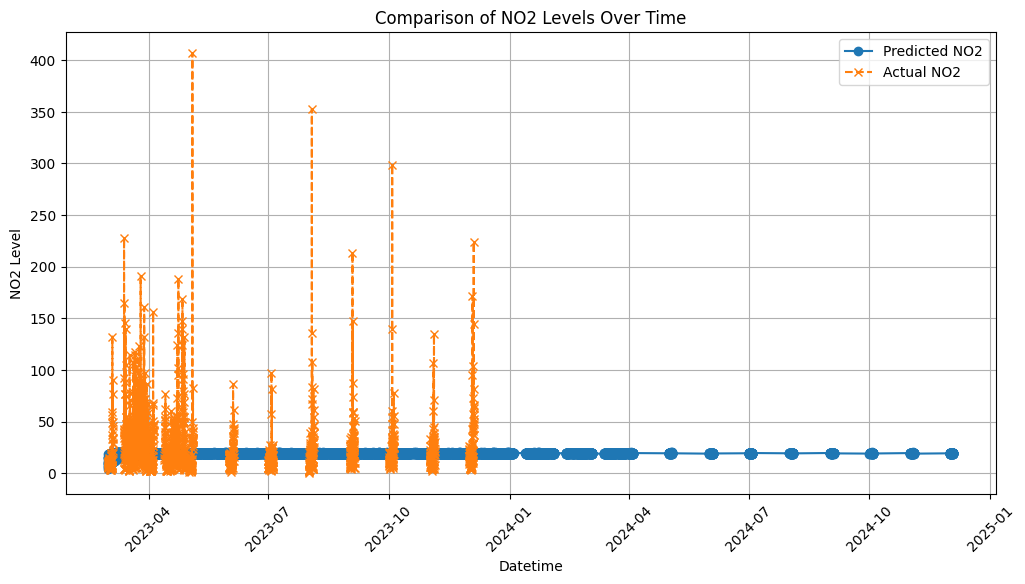

In [72]:
# 1️⃣ Line Plot - Comparing NO2 over time
plt.figure(figsize=(12, 6))
plt.plot(df_merged['Datetime'], df_merged['NO2_Predicted'], label='Predicted NO2', linestyle='-', marker='o')
plt.plot(df_merged['Datetime'], df_merged['NO2'], label='Actual NO2', linestyle='--', marker='x')
plt.xlabel('Datetime')
plt.ylabel('NO2 Level')
plt.title('Comparison of NO2 Levels Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

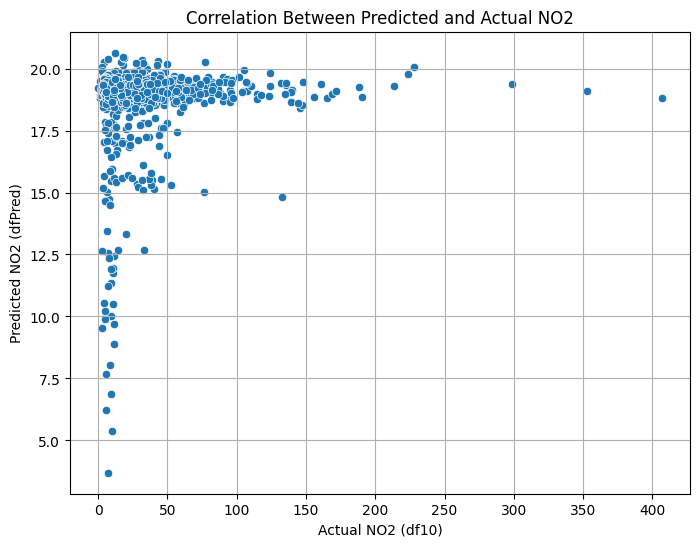

In [73]:
# Import the seaborn library
import seaborn as sns

# Scatter Plot - Checking Correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_merged['NO2'], y=df_merged['NO2_Predicted'])
plt.xlabel('Actual NO2 (df10)')
plt.ylabel('Predicted NO2 (dfPred)')
plt.title('Correlation Between Predicted and Actual NO2')
plt.grid()
plt.show()


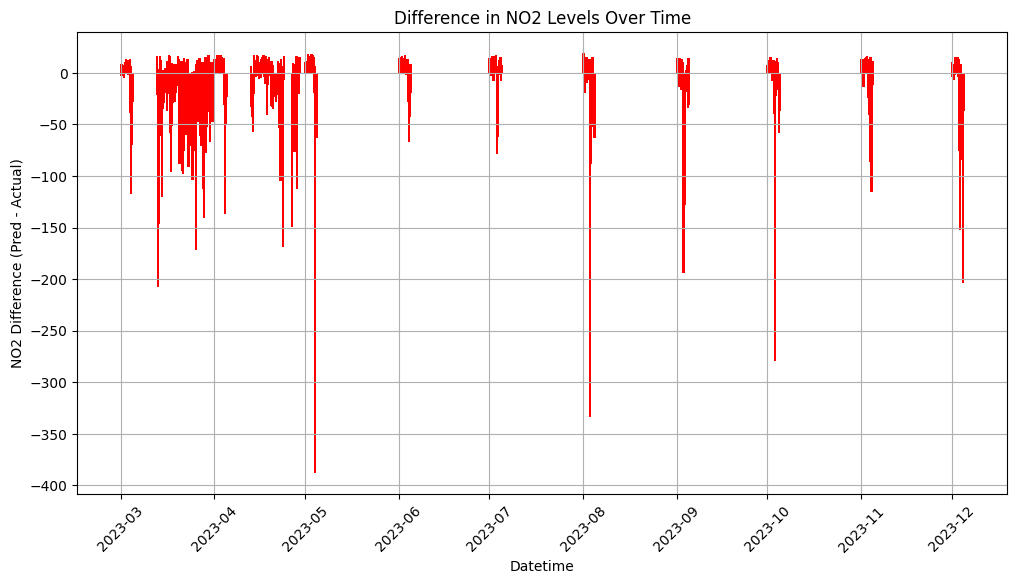

In [74]:

# 3️⃣ Difference Plot - NO2 Difference Over Time
plt.figure(figsize=(12, 6))
plt.bar(df_merged['Datetime'], df_merged['NO2_Difference'], color='red')
plt.xlabel('Datetime')
plt.ylabel('NO2 Difference (Pred - Actual)')
plt.title('Difference in NO2 Levels Over Time')
plt.xticks(rotation=45)
plt.grid()
plt.show()